In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [3]:
train= pd.read_csv('drive/MyDrive/Tredence Competition/train.csv')
test= pd.read_csv('drive/MyDrive/Tredence Competition/test.csv')
train.head()

,edible-poisonous,cap-diameter,cap-shape,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,p,5.75,x,n,t,s,w,6.13,14.93,w,f,f,d,a
1,p,2.27,o,g,f,f,f,0.00,0.00,f,f,f,d,s
2,p,5.59,c,y,t,x,p,5.47,11.27,w,f,f,d,a
3,p,0.74,x,p,f,a,n,4.33,0.98,k,f,f,d,a
4,p,9.60,x,n,f,a,w,10.84,28.52,w,f,f,d,u


In [4]:
train.shape

(42748, 14)

In [5]:
train.dtypes

edible-poisonous         object
cap-diameter            float64
cap-shape                object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-color               object
stem-height             float64
stem-width              float64
stem-color               object
has-ring                 object
ring-type                object
habitat                  object
season                   object
dtype: object

In [6]:
train.isnull().sum()

edible-poisonous           0
cap-diameter               0
cap-shape                  0
cap-color                  0
does-bruise-or-bleed       0
gill-attachment         6940
gill-color                 0
stem-height                0
stem-width                 0
stem-color                 0
has-ring                   0
ring-type               1719
habitat                    0
season                     0
dtype: int64

In [7]:
test.isnull().sum()

edible-poisonous            0
cap-diameter                0
cap-shape                   0
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          2944
gill-color                  0
stem-height                 0
stem-width                  0
stem-color                  0
has-ring                    0
ring-type                 752
habitat                     0
season                  18321
dtype: int64

In [8]:
def transform_num(df):
    df['stem-height'] = np.sqrt(df['stem-height'])
    df['stem-width'] = np.cbrt(df['stem-width'])
    df['stem-ratio'] = np.cbrt(df['stem-height']/df['stem-width'])
    df['stem-ratio'] = df['stem-ratio'].fillna(0)
    return df

In [9]:
train = transform_num(train)
test = transform_num(test)

In [10]:
def impute_nan(df,variable):
    df[variable+"_random"]=df[variable]
    ##It will have the random sample to fill the na
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    ##pandas need to have same index in order to merge the dataset
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable+'_random']=random_sample

In [11]:
impute_nan(train,'gill-attachment')
impute_nan(test,'gill-attachment')

impute_nan(train,'ring-type')
impute_nan(test,'ring-type')

In [12]:
train.drop('gill-attachment',axis=1,inplace=True)
test.drop('gill-attachment',axis=1,inplace=True)

train.drop('ring-type',axis=1,inplace=True)
test.drop('ring-type',axis=1,inplace=True)

In [13]:
train.isnull().sum()

edible-poisonous          0
cap-diameter              0
cap-shape                 0
cap-color                 0
does-bruise-or-bleed      0
gill-color                0
stem-height               0
stem-width                0
stem-color                0
has-ring                  0
habitat                   0
season                    0
stem-ratio                0
gill-attachment_random    0
ring-type_random          0
dtype: int64

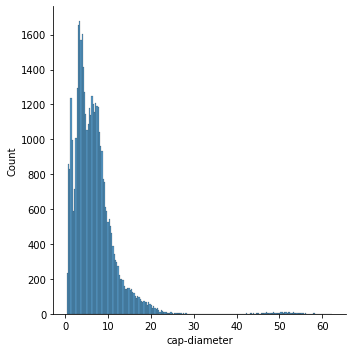

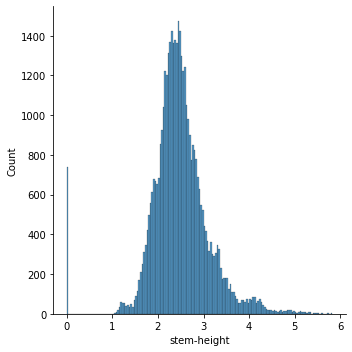

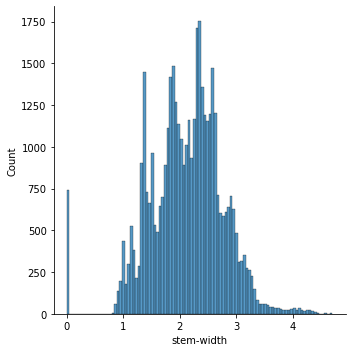

In [14]:
for i in ['cap-diameter','stem-height','stem-width']:
    sns.displot(train,x=i)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


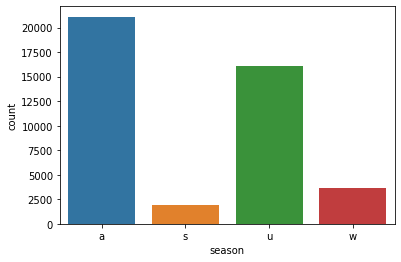

In [15]:
sns.countplot(train['season'])
plt.show()

In [16]:
test.drop('season',axis=1,inplace=True)


In [17]:
dummy_train= pd.get_dummies(train[['does-bruise-or-bleed','edible-poisonous', 'gill-color',
                                  'stem-color', 'has-ring', 'habitat','cap-shape','gill-attachment_random','ring-type_random',	'cap-color']],drop_first=True)

In [18]:
train_df= pd.concat([train,dummy_train],axis=1)

In [19]:
train_df.drop(['does-bruise-or-bleed','edible-poisonous', 'gill-color',
                                  'stem-color', 'has-ring', 'habitat','cap-shape','gill-attachment_random','ring-type_random',	'cap-color'],axis=1,inplace=True)

In [20]:
dummy_test= pd.get_dummies(test[['does-bruise-or-bleed','edible-poisonous', 'gill-color',
                                  'stem-color', 'has-ring', 'habitat','gill-attachment_random','ring-type_random','cap-shape',	'cap-color']],drop_first=True)

In [21]:
test_df= pd.concat([test,dummy_test],axis=1)

In [22]:
test_df.drop(['does-bruise-or-bleed','edible-poisonous', 'gill-color',
                                  'stem-color', 'has-ring', 'habitat','gill-attachment_random','ring-type_random','cap-shape',	'cap-color'],axis=1,inplace=True)

In [23]:
train_df.head()

,cap-diameter,stem-height,stem-width,season,stem-ratio,does-bruise-or-bleed_t,edible-poisonous_p,gill-color_e,gill-color_f,gill-color_g,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y,stem-color_e,stem-color_f,stem-color_g,stem-color_k,stem-color_l,stem-color_n,stem-color_o,stem-color_p,stem-color_r,stem-color_u,stem-color_w,stem-color_y,has-ring_t,habitat_g,habitat_h,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_p,cap-shape_s,cap-shape_x,gill-attachment_random_d,gill-attachment_random_e,gill-attachment_random_f,gill-attachment_random_p,gill-attachment_random_s,gill-attachment_random_x,ring-type_random_f,ring-type_random_g,ring-type_random_l,ring-type_random_m,ring-type_random_p,ring-type_random_r,ring-type_random_z,cap-color_e,cap-color_g,cap-color_k,cap-color_l,cap-color_n,cap-color_o,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y
0,5.75,2.475884,2.462370,a,1.001826,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2.27,0.000000,0.000000,s,0.000000,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,5.59,2.338803,2.242029,a,1.014186,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.74,2.080865,0.993288,a,1.279547,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,9.60,3.292416,3.055272,u,1.025231,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [24]:
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
train_df['season']=le.fit_transform(train_df['season'])


In [25]:
output_labels=le.classes_

In [26]:
train_df['season'].unique()

array([0, 1, 2, 3])

### **Data Augmentation**

In [27]:
# check version number
import imblearn
from collections import Counter
print(imblearn.__version__)

0.8.1


In [28]:
from sklearn.model_selection import train_test_split

X_train= train_df.drop('season',axis=1)
y_train= train_df['season']

# Create validation set
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.3,shuffle=False)

In [29]:
# getting the actual class counts and their percentage of the total class values
counter= Counter(y_train)
for k,v in counter.items():
  per= v/len(y_train)*100
  print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=14788 (49.420%)
Class=1, n=1321 (4.415%)
Class=2, n=11255 (37.613%)
Class=3, n=2559 (8.552%)


In [30]:
counter= Counter(y_val)
for k,v in counter.items():
  per= v/len(y_val)*100
  print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=6315 (49.240%)
Class=3, n=1139 (8.881%)
Class=2, n=4800 (37.427%)
Class=1, n=571 (4.452%)


In [31]:
from imblearn.over_sampling import SMOTE
strategy_train= {0:20000, 1:6000, 2:15000, 3:7000}
oversample= SMOTE(sampling_strategy=strategy_train)
X_res,y_res= oversample.fit_resample(X_train,y_train)
counter_1= Counter(y_res)
for k,v in counter_1.items():
  per= v/len(y_res)*100
  print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (20000) in class 0 will be larger than the number of samples in the majority class (class #0 -> 14788)
  f"After over-sampling, the number of samples ({n_samples})"
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (15000) in class 2 will be larger than the number of samples in the majority class (class #0 -> 14788)
  f"After over-sampling, the number of samples ({n_samples})"


Class=0, n=20000 (41.667%)
Class=1, n=6000 (12.500%)
Class=2, n=15000 (31.250%)
Class=3, n=7000 (14.583%)


In [32]:
strategy_val={0:8000,1:2200,2:5200,3:1300}
smote= SMOTE(sampling_strategy=strategy_val)
X_val_r,y_val_r= smote.fit_resample(X_val,y_val)
counter_2=Counter(y_val_r)
for k,v in counter_2.items():
  per=v/len(y_val_r)*100
  print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (8000) in class 0 will be larger than the number of samples in the majority class (class #0 -> 6315)
  f"After over-sampling, the number of samples ({n_samples})"


Class=0, n=8000 (47.904%)
Class=3, n=1300 (7.784%)
Class=2, n=5200 (31.138%)
Class=1, n=2200 (13.174%)


In [33]:

print(X_res.shape)
print(y_res.shape)

(48000, 67)
(48000,)


In [34]:
print(X_train.shape)

(29923, 67)


### **Feature Importance**

In [35]:
from sklearn.feature_selection import mutual_info_classif

mutual_info=mutual_info_classif(X_res,y_res)
mut_data=pd.Series(mutual_info,index=X_res.columns)
mut_data.sort_values(ascending=False)

stem-width                  0.115346
cap-diameter                0.103413
stem-ratio                  0.097022
stem-height                 0.080692
does-bruise-or-bleed_t      0.030102
                              ...   
gill-attachment_random_x    0.000000
stem-color_l                0.000000
habitat_w                   0.000000
habitat_p                   0.000000
gill-color_u                0.000000
Length: 67, dtype: float64

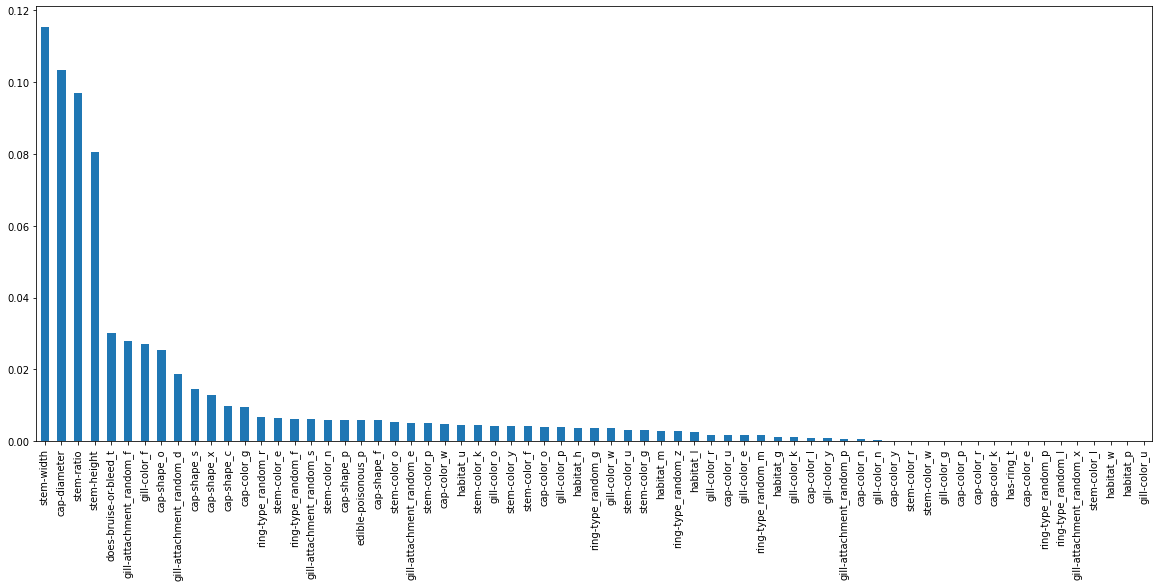

In [36]:
mut_data.sort_values(ascending=False).plot.bar(figsize=(20,8))
plt.show()

In [37]:
from sklearn.feature_selection import SelectKBest

sel_top_cols= SelectKBest(mutual_info_classif,k=45)
sel_top_cols.fit(X_res,y_res)

SelectKBest(k=45, score_func=<function mutual_info_classif at 0x7f433479b4d0>)

In [38]:
eliminate_cols=[col for col in X_res.columns
                if col not in X_res.columns[sel_top_cols.get_support()]]

print(len(eliminate_cols))

22


In [39]:
X_res.drop(eliminate_cols,axis=1,inplace=True)
X_val_r.drop(eliminate_cols,axis=1,inplace=True)

In [40]:
test_df.drop(eliminate_cols,axis=1,inplace=True)

In [41]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RandomizedSearchCV

### **Treat outliers**

 To eliminate outliers or not to is entirely upto you, as it is not black and white that eliminating outliers is necessary , there are a lot of grey areas where outliers prove to be very useful in contributing towards predictive accuracy.

In [42]:
res=pd.concat([X_res,y_res],axis=1)
res.shape

(48000, 46)

In [43]:
res['cap-diameter'].describe()

count    48000.000000
mean         6.826990
std          5.893675
min          0.380000
25%          3.500000
50%          5.780000
75%          8.560000
max         62.340000
Name: cap-diameter, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


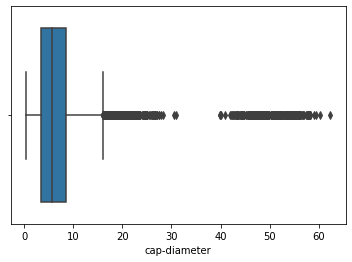

In [44]:
sns.boxplot(res['cap-diameter'])

In [45]:
def remove_outliers(data,feature):
  Q1= np.percentile(data[feature],25,interpolation='midpoint')
  Q3= np.percentile(data[feature],75,interpolation='midpoint')
  IQR= Q3-Q1
  print('Records before',data.shape[0])
  upper= np.where(data[feature]>=(Q3+1.5*IQR))
  lower= np.where(data[feature]<=(Q1-1.5*IQR))

  data.drop(upper[0],inplace=True)
  data.drop(lower[0],inplace=True)

  print('Records after outlier elimination',data.shape[0])


In [46]:
remove_outliers(res,'cap-diameter')

Records before 48000
Records after outlier elimination 46092


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


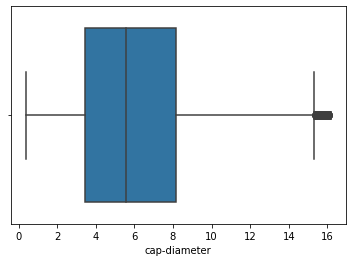

In [47]:
sns.boxplot(res['cap-diameter'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


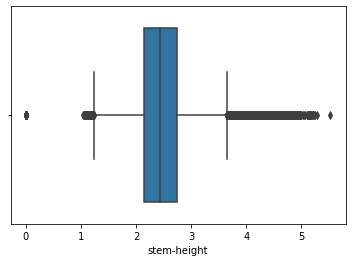

In [48]:
sns.boxplot(res['stem-height'])

In [49]:
res['stem-height'].describe()

count    46092.000000
mean         2.433646
std          0.644826
min          0.000000
25%          2.137756
50%          2.426932
75%          2.744085
max          5.523586
Name: stem-height, dtype: float64

In [50]:
percentile25 = res['stem-height'].quantile(0.25)
percentile75 = res['stem-height'].quantile(0.75)
iqr= percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

res= res[(res['stem-height']< upper_limit) & (res['stem-height']>lower_limit)]
res.shape[0]

43448

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


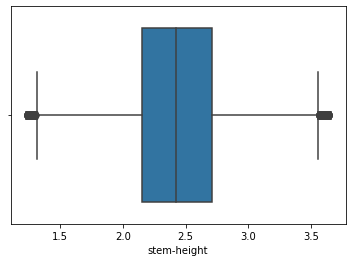

In [51]:
sns.boxplot(res['stem-height'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


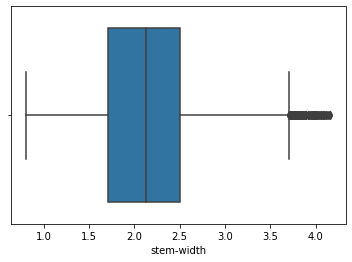

In [52]:
sns.boxplot(res['stem-width'])

In [53]:
percentile25 = res['stem-width'].quantile(0.25)
percentile75 = res['stem-width'].quantile(0.75)
iqr= percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

res= res[(res['stem-width']< upper_limit) & (res['stem-width']>lower_limit)]
res.shape[0]

43275

In [54]:
res.columns

Index(['cap-diameter', 'stem-height', 'stem-width', 'stem-ratio',
       'does-bruise-or-bleed_t', 'edible-poisonous_p', 'gill-color_e',
       'gill-color_f', 'gill-color_o', 'gill-color_p', 'gill-color_w',
       'gill-color_y', 'stem-color_e', 'stem-color_f', 'stem-color_g',
       'stem-color_k', 'stem-color_n', 'stem-color_p', 'stem-color_u',
       'stem-color_w', 'stem-color_y', 'has-ring_t', 'habitat_m', 'habitat_u',
       'cap-shape_c', 'cap-shape_f', 'cap-shape_o', 'cap-shape_p',
       'cap-shape_s', 'cap-shape_x', 'gill-attachment_random_d',
       'gill-attachment_random_f', 'gill-attachment_random_p',
       'gill-attachment_random_s', 'gill-attachment_random_x',
       'ring-type_random_f', 'ring-type_random_m', 'ring-type_random_p',
       'ring-type_random_z', 'cap-color_g', 'cap-color_l', 'cap-color_o',
       'cap-color_p', 'cap-color_r', 'cap-color_u', 'season'],
      dtype='object')

In [55]:
X_res_1= res.drop('season',axis=1)
y_res_1= res['season']
print(X_res_1.shape)
print(y_res_1.shape)

(43275, 45)
(43275,)


### **Modelling**

LGBM Classifier

In [57]:
X_val.drop(eliminate_cols,axis=1,inplace=True)

In [58]:
# Without outliers
lgb=LGBMClassifier(learning_rate=0.1,n_estimators=500,reg_lambda=0.7)
lgb.fit(X_res_1,y_res_1)
y_pred_lgb=lgb.predict(X_val)
accuracy_score(y_val,y_pred_lgb)

0.5111111111111111

In [59]:
# With outliers
lgb=LGBMClassifier(learning_rate=0.1,n_estimators=500,reg_lambda=0.7)
lgb.fit(X_res,y_res)
y_pred_lgb=lgb.predict(X_val)
accuracy_score(y_val,y_pred_lgb)

0.5171929824561403

Random Forest Classifier

In [60]:
# Without outliers
rf= RandomForestClassifier(n_estimators=600,criterion='entropy',max_features='log2')
rf.fit(X_res_1,y_res_1)
y_pred_rf=rf.predict(X_val)
accuracy_score(y_val,y_pred_rf)

0.5164912280701754

In [61]:
# with outliers
rf1= RandomForestClassifier(n_estimators=600,criterion='entropy',max_features='log2')
rf1.fit(X_res,y_res)
y_pred_rf1= rf1.predict(X_val)
accuracy_score(y_val,y_pred_rf1)

0.5207797270955166

In [62]:
pd.Series(rf1.feature_importances_,index=X_res.columns).sort_values(ascending=False)

cap-diameter                0.185572
stem-width                  0.178265
stem-ratio                  0.176085
stem-height                 0.151531
edible-poisonous_p          0.023967
does-bruise-or-bleed_t      0.017316
gill-color_w                0.015899
stem-color_w                0.015834
stem-color_n                0.015089
cap-shape_x                 0.013509
has-ring_t                  0.012406
gill-attachment_random_d    0.012079
gill-attachment_random_s    0.012046
gill-attachment_random_x    0.012037
stem-color_y                0.010357
cap-shape_f                 0.009932
gill-attachment_random_p    0.009707
gill-color_f                0.009491
cap-shape_s                 0.008989
cap-shape_o                 0.008811
ring-type_random_f          0.008588
gill-color_y                0.008486
gill-attachment_random_f    0.008122
gill-color_p                0.007721
cap-color_g                 0.006944
ring-type_random_z          0.006698
cap-color_o                 0.006146
c

XGBoost Classifier

In [63]:
# Without outliers
xgb=XGBClassifier(n_estimators=300,objective='multi:softmax')
xgb.fit(X_res_1,y_res_1)
y_xgb= xgb.predict(X_val)
accuracy_score(y_val,y_xgb)

0.5061208576998051

In [64]:
# With outliers
xgb=XGBClassifier(n_estimators=300,objective='multi:softmax')
xgb.fit(X_res,y_res)
y_xgb= xgb.predict(X_val)
accuracy_score(y_val,y_xgb)

0.5083040935672515

In [65]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 51 kB/s 


In [66]:
from catboost import CatBoostClassifier

In [67]:
cbc= CatBoostClassifier()
cbc.fit(X_res_1,y_res_1)
y_pred_cbc= cbc.predict(X_val)
accuracy_score(y_val,y_pred_cbc)

Learning rate set to 0.09589
0:	learn: 1.3383245	total: 108ms	remaining: 1m 47s
1:	learn: 1.3009713	total: 168ms	remaining: 1m 23s
2:	learn: 1.2665883	total: 236ms	remaining: 1m 18s
3:	learn: 1.2406747	total: 299ms	remaining: 1m 14s
4:	learn: 1.2148065	total: 349ms	remaining: 1m 9s
5:	learn: 1.1924365	total: 414ms	remaining: 1m 8s
6:	learn: 1.1725611	total: 487ms	remaining: 1m 9s
7:	learn: 1.1554742	total: 544ms	remaining: 1m 7s
8:	learn: 1.1381633	total: 612ms	remaining: 1m 7s
9:	learn: 1.1228705	total: 672ms	remaining: 1m 6s
10:	learn: 1.1088160	total: 733ms	remaining: 1m 5s
11:	learn: 1.0966086	total: 787ms	remaining: 1m 4s
12:	learn: 1.0830188	total: 850ms	remaining: 1m 4s
13:	learn: 1.0715641	total: 898ms	remaining: 1m 3s
14:	learn: 1.0598096	total: 940ms	remaining: 1m 1s
15:	learn: 1.0510153	total: 998ms	remaining: 1m 1s
16:	learn: 1.0433543	total: 1.03s	remaining: 59.8s
17:	learn: 1.0354880	total: 1.08s	remaining: 59.2s
18:	learn: 1.0276689	total: 1.14s	remaining: 58.7s
19:	lear

0.5077582846003899

In [68]:
cbc= CatBoostClassifier()
cbc.fit(X_res,y_res)
y_pred= cbc.predict(X_val)
accuracy_score(y_val,y_pred)

Learning rate set to 0.096398
0:	learn: 1.3472905	total: 40.3ms	remaining: 40.3s
1:	learn: 1.3133400	total: 76ms	remaining: 37.9s
2:	learn: 1.2843699	total: 106ms	remaining: 35.3s
3:	learn: 1.2560640	total: 134ms	remaining: 33.4s
4:	learn: 1.2302775	total: 162ms	remaining: 32.3s
5:	learn: 1.2101150	total: 192ms	remaining: 31.7s
6:	learn: 1.1918626	total: 220ms	remaining: 31.1s
7:	learn: 1.1738600	total: 248ms	remaining: 30.8s
8:	learn: 1.1600510	total: 275ms	remaining: 30.2s
9:	learn: 1.1462471	total: 301ms	remaining: 29.8s
10:	learn: 1.1327829	total: 328ms	remaining: 29.5s
11:	learn: 1.1217968	total: 358ms	remaining: 29.5s
12:	learn: 1.1104407	total: 385ms	remaining: 29.2s
13:	learn: 1.0990941	total: 416ms	remaining: 29.3s
14:	learn: 1.0912492	total: 445ms	remaining: 29.2s
15:	learn: 1.0842227	total: 472ms	remaining: 29s
16:	learn: 1.0736594	total: 500ms	remaining: 28.9s
17:	learn: 1.0638792	total: 526ms	remaining: 28.7s
18:	learn: 1.0553668	total: 555ms	remaining: 28.7s
19:	learn: 1.

0.517504873294347

In [69]:
pred_cbc=cbc.predict(test_df)
preds= np.array(output_labels)[pred_cbc]
prediction_cat= pd.DataFrame(preds,columns=['season'])
prediction_cat.to_csv('My_submission_final.csv',index=False)

In [70]:
prediction_cat

,season
0,s
1,a
2,u
3,a
4,u
...,...
18316,a
18317,a
18318,a
18319,u


### **Hyper parameter tuning**

This too is entirely upto you , for me the best performing model was catboost with default parameters since it helped achieve a great rank

In [ ]:
# Number of trees in random forest
n_estimators = [300, 400, 500, 600, 700]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [5, 8, 15, 25, 30]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)

{'n_estimators': [300, 400, 500, 600, 700], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [5, 8, 15, 25, 30], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [ ]:
rf=RandomForestClassifier()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=1,cv=3,verbose=2,
                               random_state=100,n_jobs=-1)
### fit the randomized model
rf_randomcv.fit(X_res,y_res)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=1,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [5, 8, 15, 25, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [300, 400, 500, 600,
                                                         700]},
                   random_state=100, verbose=2)

In [ ]:
rf_randomcv.best_score_

0.4629349138404127

In [ ]:
param_grid={
    'max_depth': range(3,10,2),
    'min_child_weight': range(1,6,1),
    'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'gamma':[i/10.0 for i in range(0,5)],
    'n_estimators':[300,400,500,600,700],
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05],
    'reg_lambda':[0.2,0.4,0.6,0.8]
}

In [ ]:
xgb= XGBClassifier()
xgb_randomcv=RandomizedSearchCV(estimator=xgb,param_distributions=param_grid,n_iter=1,cv=5,verbose=3,
                               random_state=32,n_jobs=-1)
xgb_randomcv.fit(X_res,y_res)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


RandomizedSearchCV(cv=5, estimator=XGBClassifier(), n_iter=1, n_jobs=-1,
                   param_distributions={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2, 0.3],
                                        'max_depth': range(3, 10, 2),
                                        'min_child_weight': range(1, 6),
                                        'n_estimators': [300, 400, 500, 600,
                                                         700],
                                        'reg_alpha': [0, 0.001, 0.005, 0.01,
                                                      0.05],
                                        'reg_lambda': [0.2, 0.4, 0.6, 0.8]},
                   random_state=32, verbose=3)

In [ ]:
xgb_randomcv.best_score_

0.611875754582373

In [ ]:
xgb_randomcv.best_params_

{'gamma': 0.0,
 'learning_rate': 0.3,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 600,
 'reg_alpha': 0.001,
 'reg_lambda': 0.8}

In [ ]:
XGB_model=XGBClassifier(n_estimators=600,
                        learning_rate=0.3,
                        min_child_weight=5,
                        max_depth=5,
                        gamma=0.0,
                        reg_alpha=0.001,
                        reg_lambda=0.8)

XGB_model.fit(X_res.to_numpy(),y_res.to_numpy())
y_pred= XGB_model.predict(test_df.to_numpy())

In [ ]:
pred= np.array(output_labels)[y_pred]
prediction_XG= pd.DataFrame(pred,columns=['season'])
prediction_XG.to_csv('My_sub_20.csv',index=None)